# PnP train and validation data
First, lets download the data

In [2]:
!mkdir data
!cd data && wget http://cmp.felk.cvut.cz/~mishkdmy/CVPR-RANSAC-Tutorial-2020/RANSAC-Tutorial-Data-PnP.tar.gz
!cd data && tar -xzf RANSAC-Tutorial-Data-PnP.tar.gz

mkdir: cannot create directory ‘data’: File exists
--2020-05-25 12:44:02--  http://cmp.felk.cvut.cz/~mishkdmy/CVPR-RANSAC-Tutorial-2020/RANSAC-Tutorial-Data-PnP.tar.gz
Resolving cmp.felk.cvut.cz (cmp.felk.cvut.cz)... 147.32.84.2
Connecting to cmp.felk.cvut.cz (cmp.felk.cvut.cz)|147.32.84.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 641596453 (612M) [application/x-gzip]
Saving to: ‘RANSAC-Tutorial-Data-PnP.tar.gz’

RANSAC-Tutorial-Dat 100%[===================>] 611.87M  17.4MB/s    in 35s     

2020-05-25 12:44:37 (17.4 MB/s) - ‘RANSAC-Tutorial-Data-PnP.tar.gz’ saved [641596453/641596453]



The PnP correspondences are generated with help of EPOS method http://cmp.felk.cvut.cz/epos/,

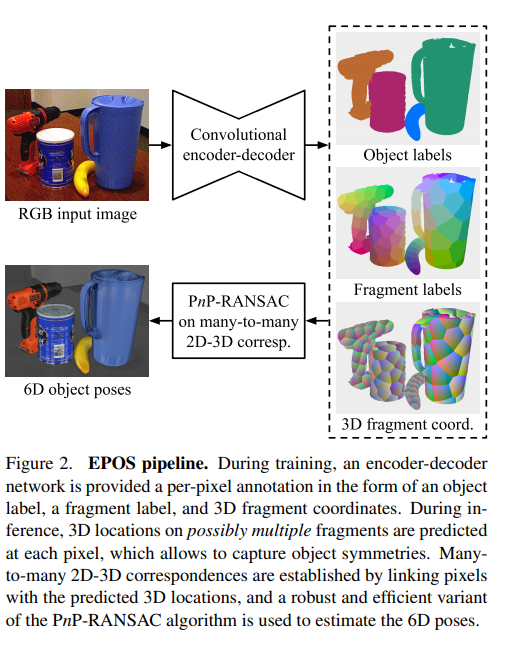

The format is as follows.  There is one txt file for each object model in each image. Note that there may be multiple instances of an object model in an image; e.g. an image from T-LESS may show multiple fuses of the same type. 

In [5]:
import numpy as np

def get_fnames(ds = 'tless', split='train'):
    if ds not in ['tless', 'ycbv', 'lmo']:
        raise ValueError(f'ds should be tless, ycbv or lmo')
    if split not in ['train', 'val']:
        raise ValueError(f'split should be train or val')
    fnames_fname = f'epos_corr_{ds}_{split}.txt'
    with open(fnames_fname, 'r') as f:
        fnames = f.readlines()
        fnames = [f'data/epos_corr_{ds}/' + x.strip() for x in fnames]
    return fnames

epos_train_fnames = get_fnames('tless', 'val')
print (epos_train_fnames[:3])

['data/epos_corr_tless/000000_05.txt', 'data/epos_corr_tless/000000_08.txt', 'data/epos_corr_tless/000000_09.txt']


A txt file contains the following:

----------------------------------------------------------------
The 1st line: scene_id image_id object_id
These ID's can be used to find the associated test image, which is at "dataset/test/scene_id/rgb/image_id.png", where dataset is lmo, tless, or ycbv (the datasets can be downloaded from the [BOP web](https://bop.felk.cvut.cz/challenges/)). The mapping of object_id to objects can be seen in Figure 1 of the BOP paper.

The 2nd to 4th line: 3x3 intrinsic matrix K.

The 5th line: The number N of ground truth poses (i.e. the number of instances of object_id visible in the image). The poses are saved as 3x4 matrices on the following 3N lines. Each pose P defines the transformation from the model coordinate system to the camera coordinate system: X_c = P * X_m, where X_c and X_m is a 3D point in the camera and the model coordinate system respectively. The 3D object models can be downloaded from the BOP web.

Then follows a line with the number M of predicted 2D-3D correspondences, each is saved on one line with this format:
u v x y z px_id frag_id conf conf_obj conf_frag
where (u, v) is the 2D image location, (x, y, z) is the predicted corresponding 3D location in the model coordinate system, px_id is the ID of a 2D location -- all correspondences with the same (u, v) have the same px_id and vice versa (note that EPOS produces possibly multiple correspondences at each pixel), frag_id is the ID of the corresponding surface fragment, and conf = conf_obj * conf_frag, where conf_obj is the predicted confidence of object object_id being visible at (u, v), and conf_frag is the predicted confidence of fragment frag_id of object object_id being visible at (u, v).

Then follows a line with the number O of the GT correspondences, each is saved on one line with this format:
u v x y z px_id frag_id gt_id
where (u, v) is the 2D image location, (x, y, z) is the corresponding GT 3D location in the model coordinate system, px_id is the ID of a 2D location (note that there is always only one GT correspondence at each pixel), frag_id is the ID of the corresponding surface fragment, and gt_id is the ID of the GT pose (0-based indexing).


In [6]:
def load_pnp_data(fname):
    out = {}
    with open(fname, 'r') as f:
        lines = f.readlines()
        lines = [x.strip() for x in lines]
    scene_id, image_id, object_id = lines[0].split(' ')
    K = lines[1].split(' ') + lines[2].split(' ') + lines[3].split(' ')
    K = np.array([float(x) for x in K]).reshape(3,3)
    poses_num = int(lines[4])
    poses = []
    for i in range(poses_num):
        p = lines[5+3*i].split(' ') + lines[5+3*i+1].split(' ') + lines[5+3*i+2].split(' ')
        poses.append(np.array([float(x) for x in p]).reshape(3,4))
    M = int(lines[5 + 3*poses_num])
    tentatives = []
    GT_corrs = []
    tent_start = 5 + 3*poses_num + 1
    tent_corrs = []
    for i, l in enumerate(lines[tent_start:]):
        data = [float(x) for x in l.split(' ')]
        if len(data) < 10:
            num_gt_start = i + tent_start
            break
        tent_corrs.append(data)
    assert M == i
    N_gt = int(lines[num_gt_start])
    for i, l in enumerate(lines[num_gt_start+1:]):
        data = [float(x) for x in l.split(' ')]
        GT_corrs.append(data)
    assert len(GT_corrs) == N_gt
    tent_corrs = np.array(tent_corrs)
    GT_corrs = np.array(GT_corrs)
    return {'scene_id': scene_id,
            'image_id': image_id,
            'object_id': object_id,
           'K': K,
           'poses': poses,
           'tentatives': tent_corrs,
           'GT_corrs': GT_corrs}

out = load_pnp_data(epos_train_fnames[0])
print (out)

{'scene_id': '11', 'image_id': '262', 'object_id': '5', 'K': array([[1.07565088e+03, 0.00000000e+00, 3.66068878e+02],
       [0.00000000e+00, 1.07390344e+03, 2.86721588e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]), 'poses': [array([[ 7.25698122e-02,  9.97245533e-01,  1.53287385e-02,
        -1.12992001e+01],
       [ 6.74482530e-01, -3.77487843e-02, -7.37325129e-01,
        -7.42169037e+01],
       [-7.34715549e-01,  6.38465125e-02, -6.75364112e-01,
         8.34592834e+02]])], 'tentatives': array([[ 3.38000000e+02,  1.98000000e+02,  3.61760672e+01, ...,
         9.97091115e-01,  9.99851108e-01,  9.97239590e-01],
       [ 3.38000000e+02,  1.94000000e+02,  3.29192969e+01, ...,
         9.96968508e-01,  9.99823868e-01,  9.97144163e-01],
       [ 3.42000000e+02,  1.98000000e+02,  3.64231447e+01, ...,
         9.96409595e-01,  9.99829531e-01,  9.96579468e-01],
       ...,
       [ 3.82000000e+02,  2.58000000e+02, -4.29802287e+01, ...,
         1.72738787e-02,  1.68400735